In [13]:
using SpiDy
using NPZ
using DataFrames
using CSV
using ProgressMeter
using Random
using Statistics
using LinearAlgebra
using Plots

########################
########################

Δt = .1
N = 300
tspan = (0., N*Δt)
saveat = (0:1:N)*Δt
α = 0.16
ω0 = 1.4
Γ = 0.5
J = LorentzianSD(α, ω0, Γ) # coloring the noise
matrix = IsoCoupling(1)

T = .01
noise = ClassicalNoise(T);

nspin = 1 # number of spins (nspin * nspin)

s0 = zeros(3*nspin*nspin)
for i in 1:nspin
    ϵ = 0.1
    s0tmp = [ϵ*rand(), ϵ*rand(), -1]
    s0[1+(i-1)*3:3+(i-1)*3] = s0tmp./norm(s0tmp)
end
J0 = 1.
JH = NNlattice(nspin, J0, J0, boundary=:periodic)

nruns = 100

100

In [14]:
println("Starting...")
progress = Progress(nruns);

sols = zeros(nruns, length(saveat), 3*nspin*nspin)

Threads.@threads for i in 1:nruns
    bfields = [bfield(N, Δt, J, noise),
               bfield(N, Δt, J, noise),
               bfield(N, Δt, J, noise)];
    sol = diffeqsolver(s0, tspan, J, bfields, matrix; JH=JH, saveat=saveat)
    print(size(sol))
    sols[i, :, :] = transpose(sol[:, :])
    next!(progress)
end

solavg = mean(sols, dims=1)[1, :, :];
solstd = std(sols, dims=1)[1, :, :];

Starting...
(3, 301)(3, 301)

Progress:   2%|▉                                        |  ETA: 0:00:31

(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)(3, 301)

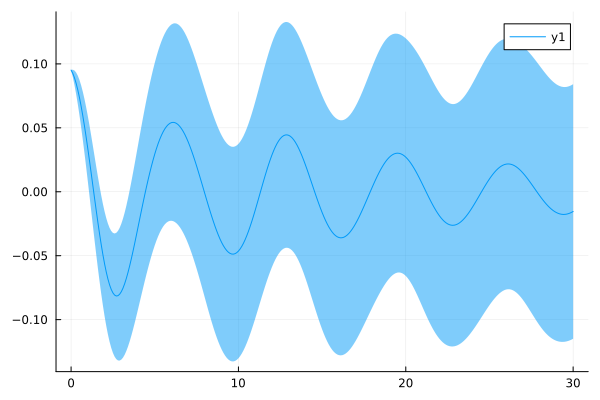

In [3]:
plot(saveat, solavg[:, 1], ribbon=solstd[:, 1])

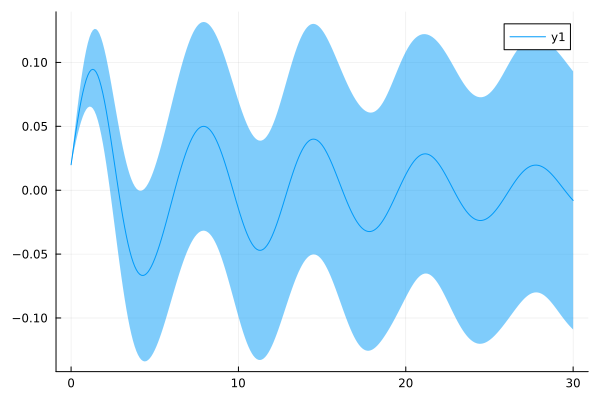

In [4]:
plot(saveat, solavg[:, 2], ribbon=solstd[:, 2])

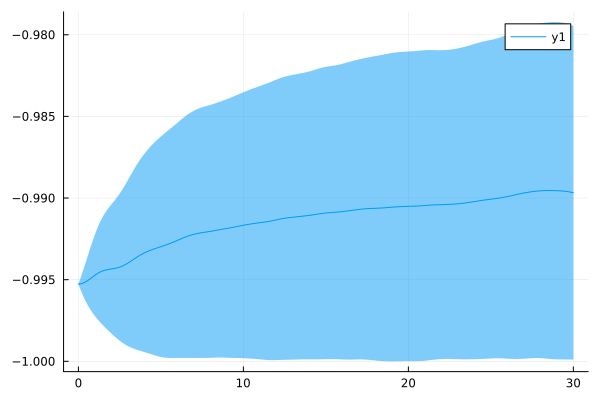

In [5]:
plot(saveat, solavg[:, 3], ribbon=solstd[:, 3])

In [6]:
projected = zeros(nruns, length(saveat), 2)

normalized_avg = [normalize(vec(row)) for row in eachrow(solavg)]

Threads.@threads for i in 1:length(saveat)
    n = normalized_avg[i, :][1]

    u = normalize(cross(n, [0,0,1]))
    v = cross(u, n)

    for j in 1:nruns
        b = sols[j, i, :]
        proj = dot(b, n) * n
        b_ort = b - proj

        projected[j, i, 1] = dot(u,b)
        projected[j, i, 2] = dot(v,b)
    end
end

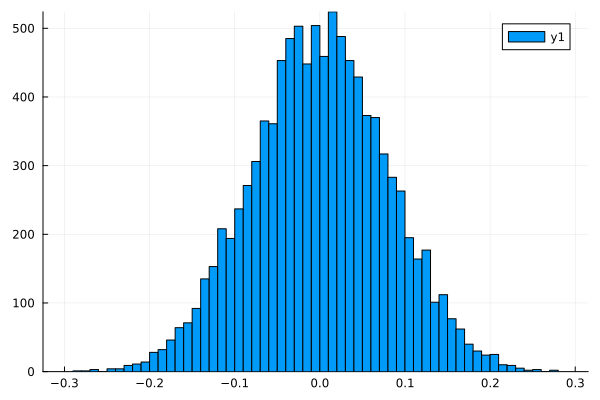

In [16]:
histogram(projected[:, 70, 1])

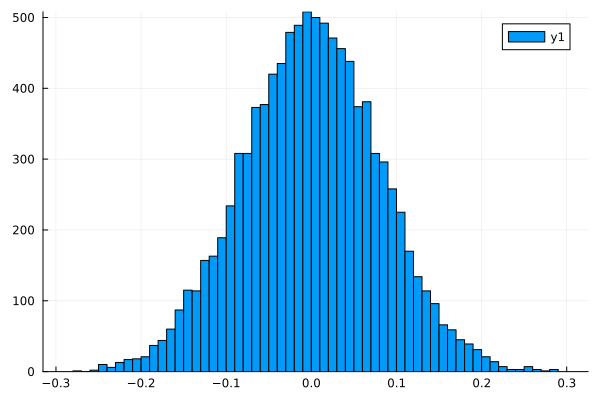

In [15]:
histogram(projected[:, 70, 2])

In [9]:
function nth_moment(data, N)
    return mean(data .^ N)
end

nth_moment (generic function with 1 method)

In [10]:
using HypothesisTests

In [11]:
JB = zeros(N)
for i in 10:N
    JB[i] = HypothesisTests.JarqueBeraTest(projected[:, i, 1]).JB
end

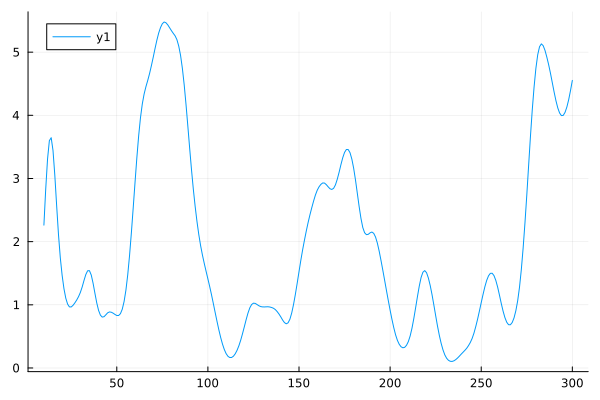

In [12]:
plot(10:N, JB[10:N])

In [13]:
HypothesisTests.JarqueBeraTest(projected[:, 197, 1])

Jarque-Bera normality test
--------------------------
Population details:
    parameter of interest:   skewness and kurtosis
    value under h_0:         "0 and 3"
    point estimate:          "0.024334226316224686 and 2.969023598052513"

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.4999

Details:
    number of observations:         10000
    JB statistic:                   1.38673


In [14]:
HypothesisTests.JarqueBeraTest(projected[:, 200, 1])

Jarque-Bera normality test
--------------------------
Population details:
    parameter of interest:   skewness and kurtosis
    value under h_0:         "0 and 3"
    point estimate:          "0.019720125889005284 and 2.974701096764015"

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.6329

Details:
    number of observations:         10000
    JB statistic:                   0.91482
